In [ ]:
#Data From Kaggle. Sorted to 10 Classes
!unzip /content/drive/MyDrive/garbage_data.zip

In [ ]:
import os

In [ ]:
dirs = ['battery','biological','cardboard','clothes','glass','metal','paper','plastic','shoes','trash']
len(dirs)

10

In [ ]:
os.mkdir('garbage_data')

In [ ]:
for i in dirs:
  os.rename(i, f'garbage_data/{i}')

In [ ]:
data_dir = 'garbage_data/'

In [ ]:
dir_lens = [len(os.listdir(data_dir+i)) for i in dirs]

In [ ]:
os.mkdir('test_data')

In [ ]:
import random

In [ ]:
for classes in os.listdir('garbage_data'):
  number_of_images = round(len(os.listdir('garbage_data/'+classes)) * 0.1)

  test_images = random.sample(os.listdir('garbage_data/'+classes), number_of_images)

  for img in test_images:
    os.rename('garbage_data/'+classes+'/'+img, 'test_data/'+img)

In [ ]:
len(os.listdir('test_data'))

1789

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
from PIL import Image

import pandas as pd
import seaborn as sns

In [ ]:
batch_size = 32
img_height = 256
img_width = 256
img_size = (256,256)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16116 files belonging to 10 classes.
Using 12893 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16116 files belonging to 10 classes.
Using 3223 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


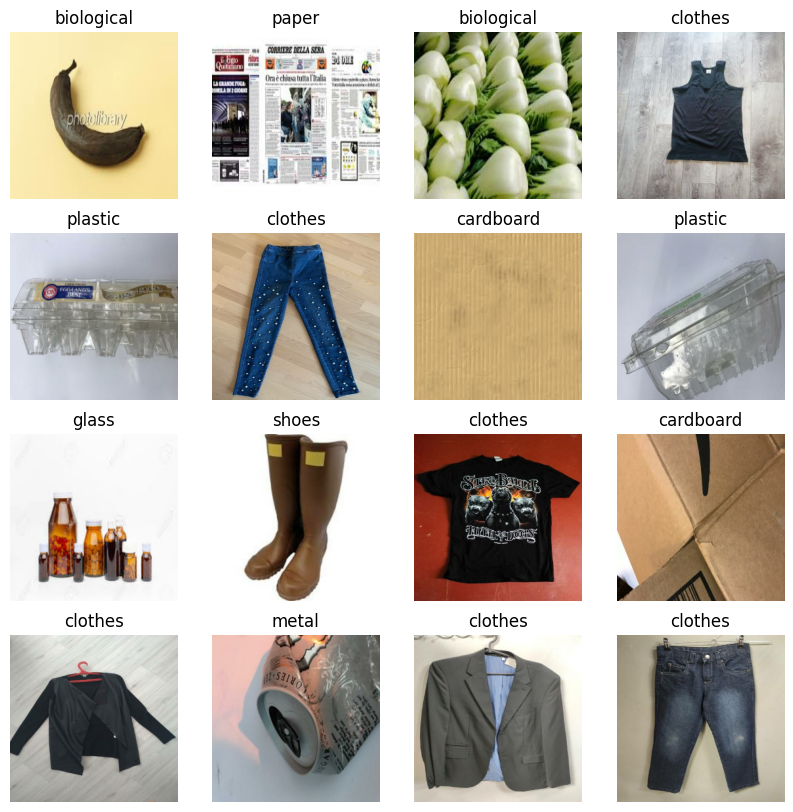

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [ ]:
"""AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)"""


"""AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache("cache/train_cache.tfdata").shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache("cache/val_cache.tfdata").prefetch(buffer_size=AUTOTUNE)"""

'AUTOTUNE = tf.data.AUTOTUNE\n\ntrain_ds = train_ds.cache("cache/train_cache.tfdata").shuffle(1000).prefetch(buffer_size=AUTOTUNE)\nval_ds = val_ds.cache("cache/val_cache.tfdata").prefetch(buffer_size=AUTOTUNE)'

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9947965


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
403/403 [==============================] - 42s 75ms/step - loss: 1.3316 - accuracy: 0.5539 - val_loss: 0.9984 - val_accuracy: 0.6562
Epoch 2/10
403/403 [==============================] - 34s 83ms/step - loss: 0.8370 - accuracy: 0.7202 - val_loss: 0.8096 - val_accuracy: 0.7276
Epoch 3/10
403/403 [==============================] - 29s 72ms/step - loss: 0.5598 - accuracy: 0.8138 - val_loss: 0.7968 - val_accuracy: 0.7608
Epoch 4/10
403/403 [==============================] - 39s 96ms/step - loss: 0.3317 - accuracy: 0.8929 - val_loss: 0.8879 - val_accuracy: 0.7679
Epoch 5/10
403/403 [==============================] - 38s 92ms/step - loss: 0.2009 - accuracy: 0.9365 - val_loss: 1.0592 - val_accuracy: 0.7766
Epoch 6/10
403/403 [==============================] - 33s 82ms/step - loss: 0.1128 - accuracy: 0.9656 - val_loss: 1.1841 - val_accuracy: 0.7716
Epoch 7/10
403/403 [==============================] - 33s 81ms/step - loss: 0.1125 - accuracy: 0.9663 - val_loss: 1.2391 - val_accuracy:

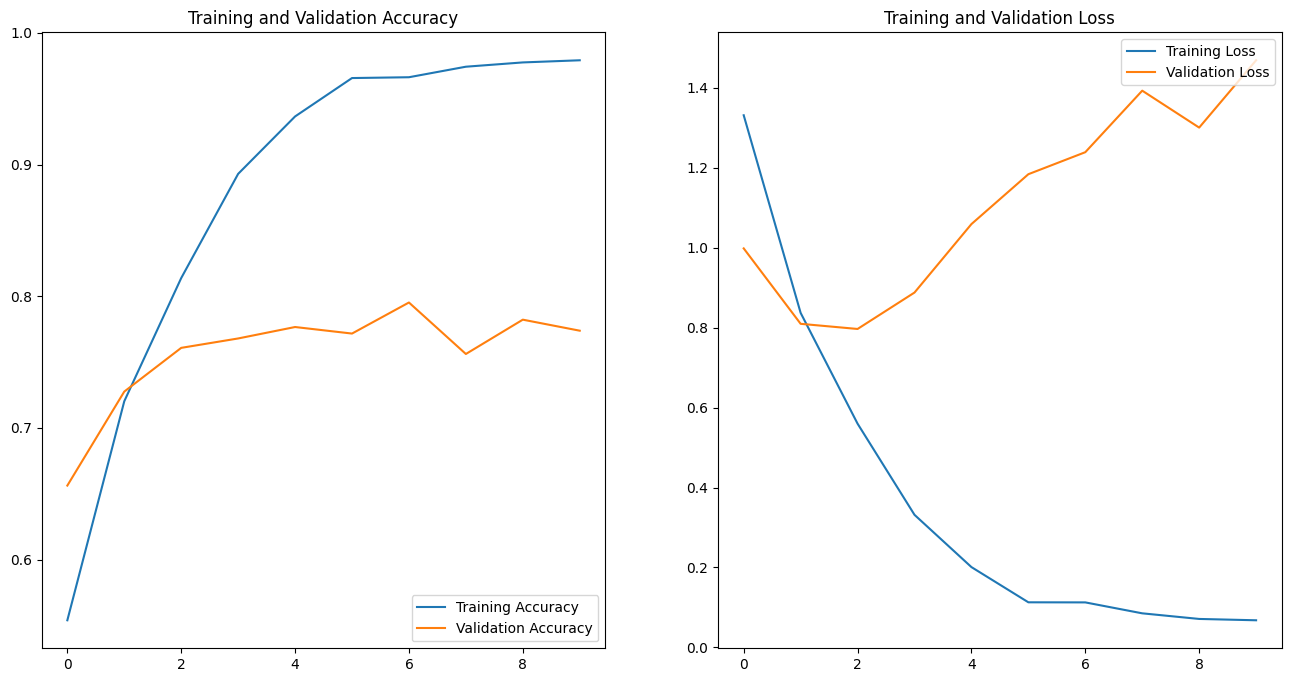

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

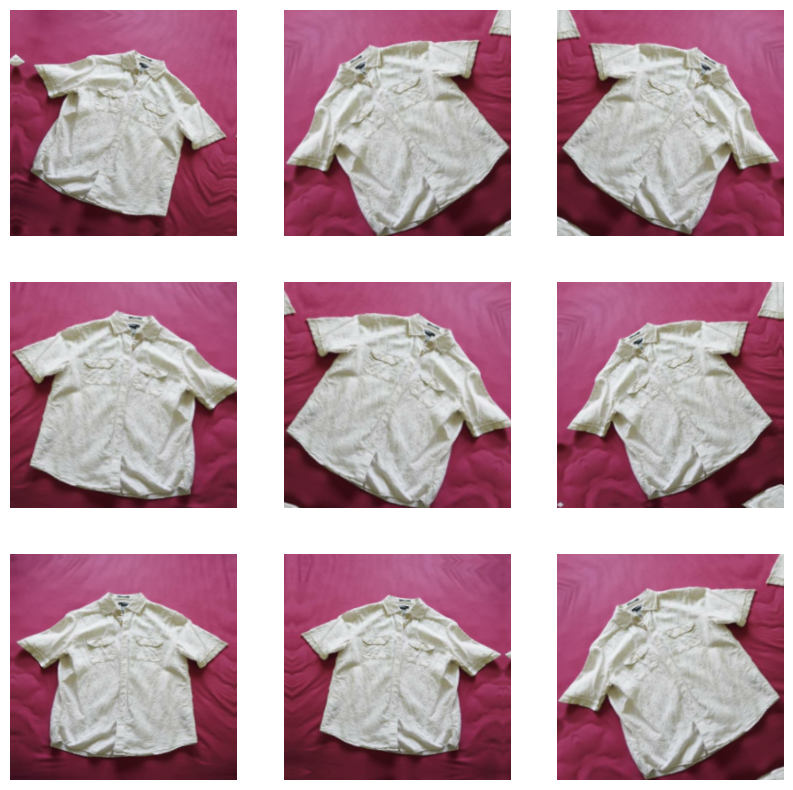

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

model.save('/content/drive/MyDrive/garbage_data_classifier_final.keras')

Epoch 1/50
403/403 [==============================] - 38s 88ms/step - loss: 1.4987 - accuracy: 0.4949 - val_loss: 1.2504 - val_accuracy: 0.5650
Epoch 2/50
403/403 [==============================] - 33s 82ms/step - loss: 1.1095 - accuracy: 0.6147 - val_loss: 1.0680 - val_accuracy: 0.6174
Epoch 3/50
403/403 [==============================] - 32s 79ms/step - loss: 1.0057 - accuracy: 0.6581 - val_loss: 0.9870 - val_accuracy: 0.6655
Epoch 4/50
403/403 [==============================] - 34s 83ms/step - loss: 0.9370 - accuracy: 0.6815 - val_loss: 0.8491 - val_accuracy: 0.7099
Epoch 5/50
403/403 [==============================] - 33s 81ms/step - loss: 0.8666 - accuracy: 0.7090 - val_loss: 0.8911 - val_accuracy: 0.7111
Epoch 6/50
403/403 [==============================] - 33s 80ms/step - loss: 0.8126 - accuracy: 0.7256 - val_loss: 0.7926 - val_accuracy: 0.7415
Epoch 7/50
403/403 [==============================] - 33s 81ms/step - loss: 0.7760 - accuracy: 0.7408 - val_loss: 0.8294 - val_accuracy:

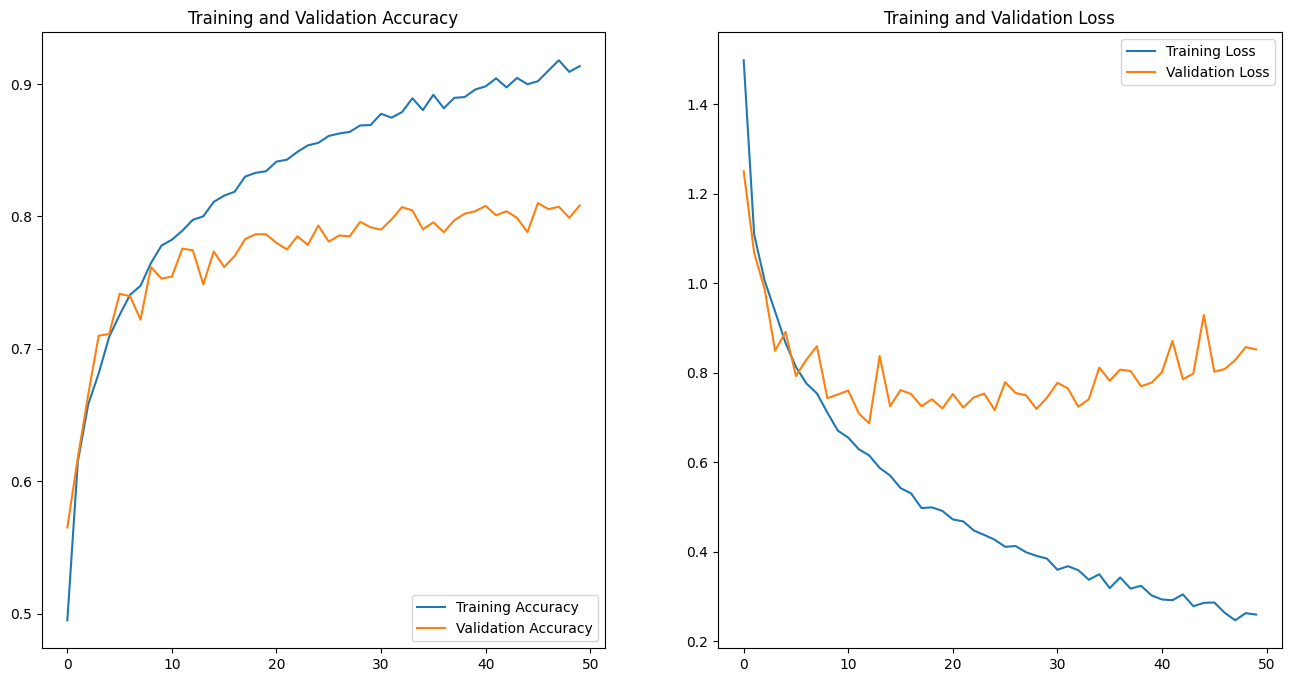

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def make_predictions(image):
  img = tf.keras.utils.load_img(image, target_size=(img_height, img_width))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  #plt.imshow(img)

  #print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
  return class_names[np.argmax(score)], 100*np.max(score)


In [ ]:
for img in os.listdir('test_data')[:1]:
  image = 'test_data/'+img
  true_class = img.split('_')[0]
  predicted_class = make_predictions(image)
  print(true_class, predicted_class)

1/1 [==============================] - 0s 20ms/step
clothes clothes


In [ ]:
correct = []

for img in os.listdir('test_data'):
  image = 'test_data/'+img
  true_class = img.split('_')[0]
  predicted_class = make_predictions(image)
  if true_class == predicted_class:
    correct.append(1)
  else:
    correct.append(0)
print(sum(correct))

In [ ]:
sum(correct)

73

In [ ]:
sum(correct)/ len(correct)

0.7998882057015092

test_data/battery_405.jpg
1/1 [==============================] - 0s 25ms/step
test_data/plastic_688.jpg
1/1 [==============================] - 0s 23ms/step
test_data/clothes_2320.jpg
1/1 [==============================] - 0s 22ms/step
test_data/biological_366.jpg
1/1 [==============================] - 0s 30ms/step
test_data/clothes_2508.jpg
1/1 [==============================] - 0s 23ms/step
test_data/plastic_746.jpg
1/1 [==============================] - 0s 26ms/step
test_data/glass_2_142.jpg
1/1 [==============================] - 0s 21ms/step
test_data/cardboard_2_340.jpg
1/1 [==============================] - 0s 23ms/step
test_data/battery_190.jpg
1/1 [==============================] - 0s 24ms/step
test_data/plastic_239.jpg
1/1 [==============================] - 0s 21ms/step
test_data/cardboard_572.jpg
1/1 [==============================] - 0s 25ms/step
test_data/clothes_1147.jpg
1/1 [==============================] - 0s 20ms/step
test_data/biological_244.jpg
1/1 [==================

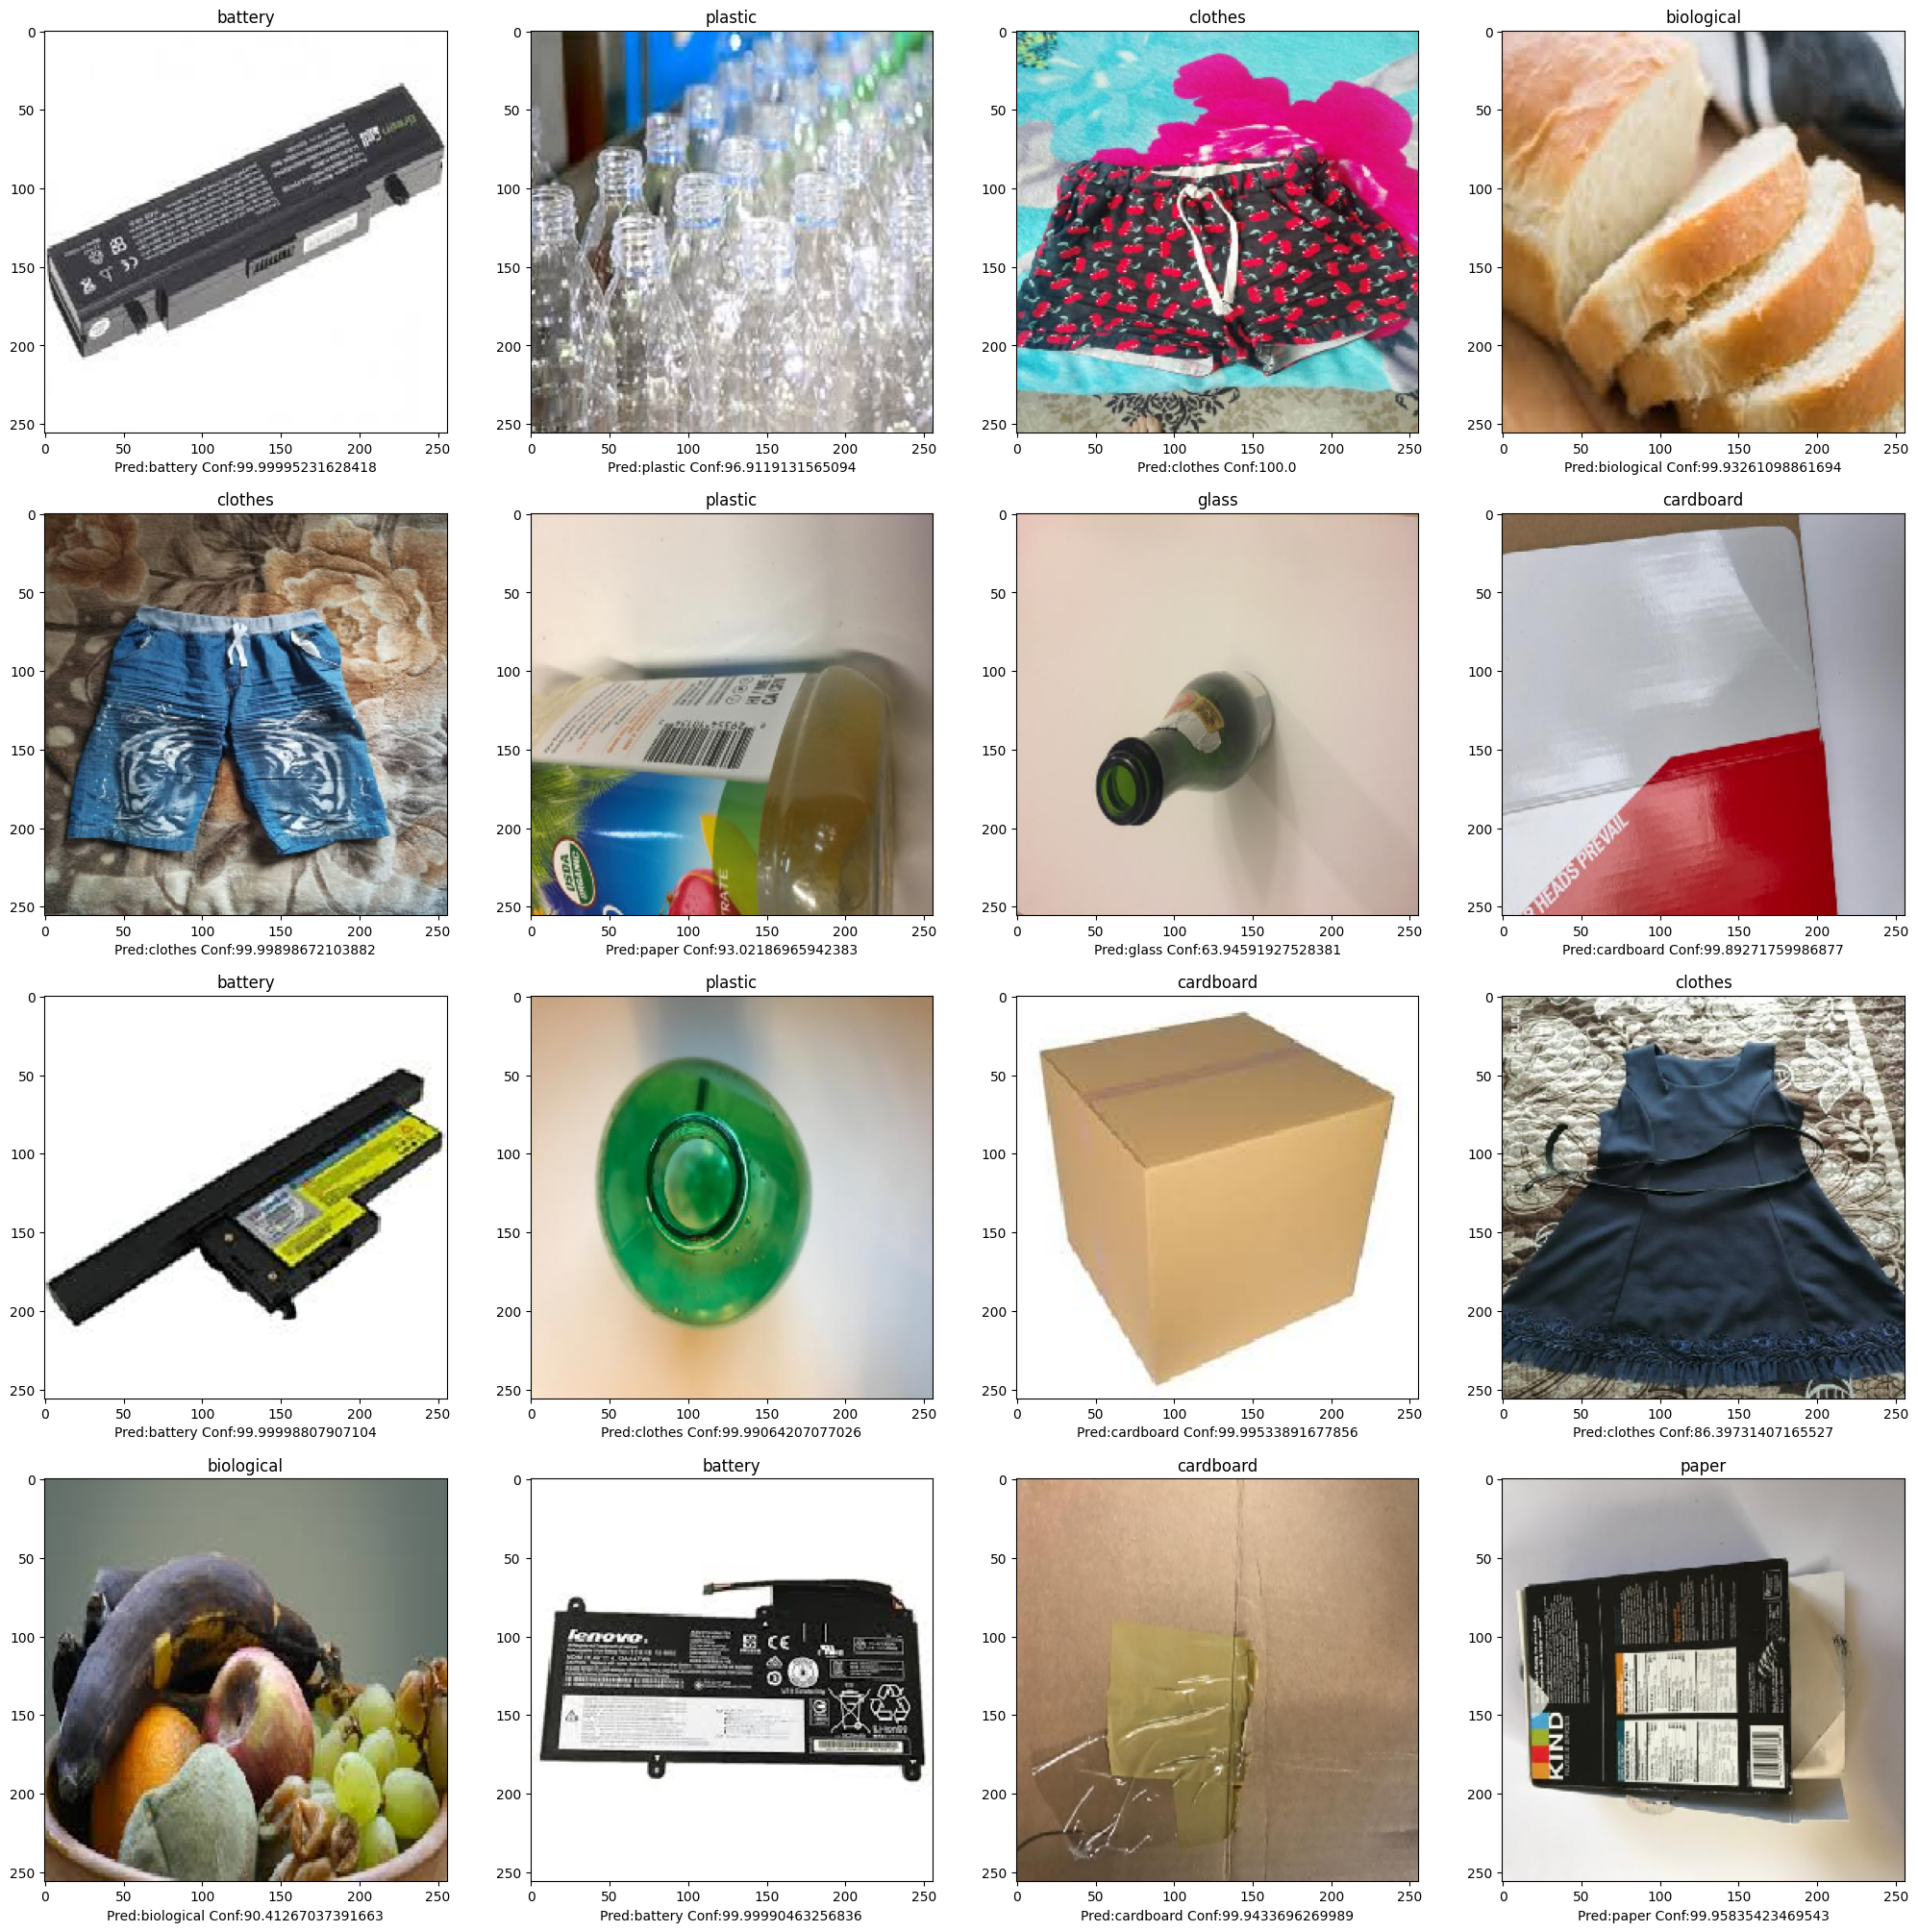

In [ ]:
plt.figure(figsize=(25, 25))

test_images = random.sample(os.listdir('test_data'), 16)

for i in range(len(test_images)):
  image = 'test_data/'+test_images[i]
  print(image)
  true_class = test_images[i].split('_')[0]

  predicted_class, confidence = make_predictions(image)
  ax = plt.subplot(4,4, i+1)
  plt.imshow(tf.keras.utils.load_img(image, target_size=(img_height, img_width)))
  plt.title(true_class)
  plt.xlabel(f'Pred:{predicted_class} Conf:{confidence}')